In [1]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms, models, datasets
from PIL import Image
from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently operating on {device}')
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from random import shuffle, seed 
from glob import glob
from torchsummary import summary

Currently operating on cpu


In [2]:
#Sort values in the csv values to concord with the file
df = pd.read_csv('~/Documents/CLG-PROJECT/pro-pic/RDataset/metadata.csv')

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Goutham/Documents/CLG-PROJECT/pro-pic/RDataset/metadata.csv'

In [3]:
mypath = '/Users/adlnzmnzr/Documents/CLG-PROJECT/pro-pic/RDataset/Images'
#Organize clean and dirty images in two sections
clean = glob(mypath + '/clean*')
dirty = glob(mypath + '/dirty*')
fpaths = clean+dirty
# Check the len of our images file and len of our dataframe
print(f'CSV shape: {df.shape}, img_file shape: {len(fpaths)}')

CSV shape: (237, 2), img_file shape: 237


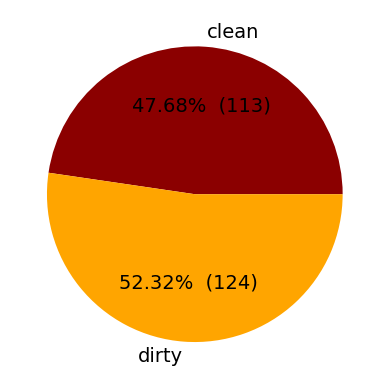

In [4]:
#df.sort_values(by="filename", key=lambda column: column.map(lambda e: fpaths_split.index(e)), inplace=True)
#df = df.reset_index(drop=True)


# Plot to see the distribution 
df_label = df['label'].value_counts()
plt.figure(figsize=plt.figaspect(1))
values = [df_label[0], df_label[1]]
labels = ['clean', 'dirty']
colors = ['darkred','orange']
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.pie(values, labels=labels, autopct=make_autopct(values), textprops={'fontsize': 14}, colors = colors)
plt.style.use('classic')
plt.show()

In [5]:
fpaths_train = fpaths[21:-19]
fpaths_test = fpaths[0:21]
fpaths_test.extend(fpaths[-19:])

#If you want to make sure that there is no same images in both files - run the following code:
check =  any(item in fpaths_test for item in fpaths_train)
 
if check is True:
    print("The test list  contains some elements of the train list ")    
else :
    print("No, test list doesn't have any elements of the train list.")

No, test list doesn't have any elements of the train list.


In [6]:
class clean_dirty(Dataset):
    def __init__(self, folder):
        #clean = glob(folder + '/clean*')
        #dirty = glob(folder + '/dirty*')
        self.fpaths = folder
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std = [0.229, 0.224, 0.225])
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dirty') for fpath in self.fpaths]
    def __len__(self):
        return len(self.fpaths)
    def __getitem__ (self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
/Users/adlnzmnzr/Documents/CLG-PROJECT/pro-pic/RDataset/Images/clean_81.jpg
tensor([0.])


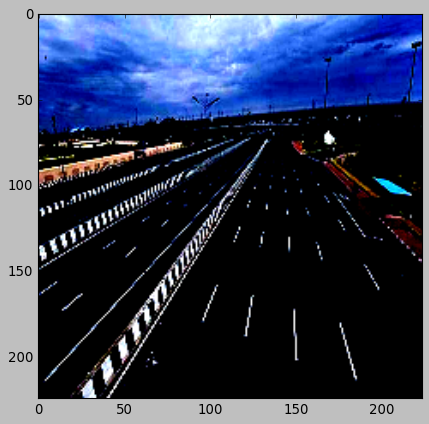

In [7]:
train = clean_dirty(fpaths_test)
import random

idx = random.randint(0, len(train)-1)

im, label = train[idx]
print(im.shape)
print(train.fpaths[idx])
plt.imshow(im.permute(1,2,0).to('cpu')) # Don't forget to load the image on cpu since Matplot does not operate with cuda 
print(label)

In [8]:
model = models.vgg16(pretrained = True).to(device)
summary(model, input_size = (3,224,224))

/Users/adlnzmnzr/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adlnzmnzr/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [9]:
def get_model():
    model = models.vgg16(pretrained = True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512,128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128,1),
                                     nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    return model.to(device), loss_fn, optimizer


In [10]:
custom_model, criterion, optimizer = get_model()
summary(custom_model, input_size = (3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()  
    return batch_loss.item()

@torch.no_grad() #This is a decorator that blocks and gradient computations for our accuracy function.
def accuracy(x,y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

def get_data():

    train_data = clean_dirty(fpaths_train)
    test_data = clean_dirty(fpaths_test)

    trn_dl = DataLoader(train_data, batch_size = 32, shuffle = True, 
                        drop_last = True)
    val_dl = DataLoader(test_data, batch_size = 32, shuffle = True, 
                        drop_last = True)
    
    return trn_dl, val_dl

In [12]:
trn_dl, val_dl = get_data()
model,loss_fn, optimizer = get_model()

In [13]:
train_losses, train_accuracies = [], []
val_accuracies = []

# xtr = torch.empty((32,3,224,224))

for epoch in range(15):#changed it for speed
    print(f'epoch {epoch+1}/15')
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        # print(x.shape)
        batch_loss = train_batch(x,y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    print(f'Loss for current epoch of {epoch+1} is {train_epoch_loss}')

    
    for ix, batch in enumerate(iter(trn_dl)):
        x,y = batch
        is_correct = accuracy(x,y,model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f'Accuracy the for current epoch of {epoch+1} is {train_epoch_accuracy}')
    
    for ix, batch in enumerate(iter(val_dl)):
        x,y = batch
        val_is_correct = accuracy(x,y,model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    print(f'Val accuracy for current epoch of {epoch+1} is {val_epoch_accuracy}')
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

epoch 1/15
Loss for current epoch of 1 is 0.5644914706548055
Accuracy the for current epoch of 1 is 0.9479166666666666
Val accuracy for current epoch of 1 is 0.9375
epoch 2/15
Loss for current epoch of 2 is 0.3341192950805028
Accuracy the for current epoch of 2 is 0.9635416666666666
Val accuracy for current epoch of 2 is 0.9375
epoch 3/15
Loss for current epoch of 3 is 0.19453621531526247
Accuracy the for current epoch of 3 is 0.9635416666666666
Val accuracy for current epoch of 3 is 0.9375
epoch 4/15
Loss for current epoch of 4 is 0.1337052813420693
Accuracy the for current epoch of 4 is 0.9635416666666666
Val accuracy for current epoch of 4 is 0.9375
epoch 5/15
Loss for current epoch of 5 is 0.11322558919588725
Accuracy the for current epoch of 5 is 0.9635416666666666
Val accuracy for current epoch of 5 is 0.96875
epoch 6/15
Loss for current epoch of 6 is 0.0781037329385678
Accuracy the for current epoch of 6 is 0.96875
Val accuracy for current epoch of 6 is 0.9375
epoch 7/15
Loss fo

/var/folders/y3/c7jgmxjj369gfx84rl2ybgnr0000gp/T/ipykernel_1216/2099564227.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


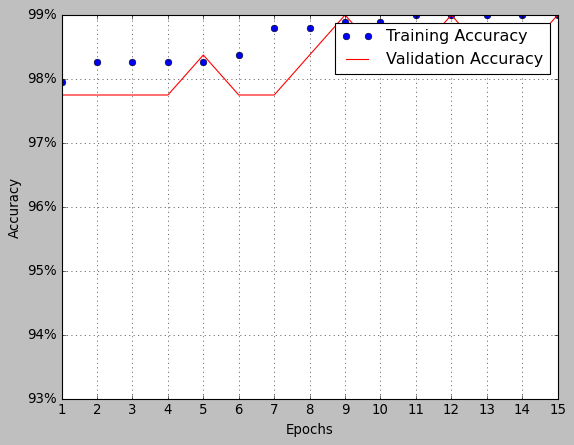

In [14]:
import matplotlib.ticker as mticker
from matplotlib.pyplot import figure

epochs = np.arange(15) + 1
figure(figsize=(8, 6), dpi=80)
plt.plot(epochs, train_accuracies, 'bo',
         label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r',
         label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.ylim(0.70,1)
plt.legend()
plt.grid('off')
plt.show()
    

In [16]:
import urllib
import cv2


def predict_custom_img(url):
    
    resp = urllib.request.urlopen(url)
    img = np.asarray(bytearray(resp.read()), dtype = 'uint8')
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img, (224,224))
    img1 = torch.tensor(img1/255).permute(2,0,1).to(device).float()
    img1 = torch.unsqueeze(img1,0)
    img1 = img1.permute(0,1,2,3)
    print(img1.shape)
    prediction = model(img1)
    if prediction < 0.5:
        a = str(f'This is a clean street with a score: {prediction}')
    else:
        a = str(f'This is a dirty street with a score: {prediction}')
    plt.style.use('dark_background')
    plt.imshow(img)
    plt.title(a)
    return img1

torch.Size([1, 3, 224, 224])


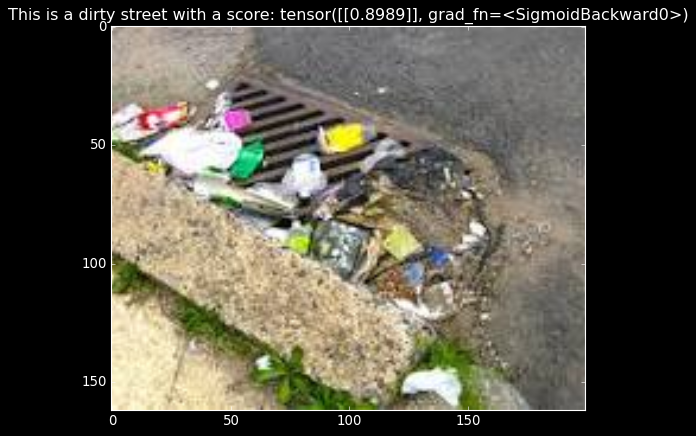

In [20]:
img = predict_custom_img('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRxQQ-W2MmOaBmmBoOX0siHCFnQlRNOqquYBkUm8h2iRQ&s')